# TODO
- revise the whole initial training procedure (create a list of steps and implement them)
- get the pipeline with a GPR model working

Problems:
- translating the procedure into code that uses searchep

# Testing

In [6]:
import numpy as np
from searchep.data import stepwise_grouping, initial_dataset_old, Data
from searchep.gpr import gp_2d_diff_kappa, gp_2d_sum_kappa
from searchep.GPFlow_model_class import GPFlowModel
from searchep.zero_search import zero_search

# 1) create a hamiltonian
def H(kappa: complex):
    hamiltonian = np.zeros((5, 5), dtype=complex)
    # 2×2 “EP block” with coalescing eigenvalues +- kappa
    hamiltonian[0, 1] = 1
    hamiltonian[1, 0] = kappa
    
    hamiltonian[2, 2] = 2.0
    hamiltonian[3, 3] = 3.0
    hamiltonian[4, 4] = 4.0
    return hamiltonian
    

In [3]:
# 2) sample a closed loop in the complex-kappa plane
def sample_orbit(center_kappa, radius, num_points):
    angles = np.linspace(0, 2*np.pi, num_points, endpoint=False)
    kappa_values = center_kappa + radius * np.exp(1j * angles)
    return kappa_values, angles

initial_kappa = 0.5 + 0.5j
radius        = 1.0
num_points    = 200

kappa_values, phi_values = sample_orbit(initial_kappa, radius, num_points)

# 3) compute raw eigenvalues along that orbit
eigenvalues_raw = np.vstack([
    np.linalg.eigvals(H(kappa_val))
    for kappa_val in kappa_values
])  # shape: (num_points, matrix_dimension)

# 4) prepare real‐valued features [Re, Im] for grouping
features = np.stack([eigenvalues_raw.real, eigenvalues_raw.imag], axis=2)  # (num_points, dimension, 2)
normalized_features = features / np.linalg.norm(features, axis=2, keepdims=True)

# 5) stepwise grouping 
grouped_features = stepwise_grouping(features) #, normalized_features)
eigenvalues_grouped = grouped_features[..., 0] + 1j * grouped_features[..., 1]  # (num_points, dimension)

# 6) extract p and s
initial_ds = initial_dataset_old(features, normalized_features)  # shape: (num_points, 2)
p_values = initial_ds[:, 0]  # difference: (lambda_1 - lambda_2)**2
s_values = initial_ds[:, 1]  # sum: (lambda_1 + lambda_2) / 2

# 7) build a Data object for GPR
# create an “empty” Data object without running __init__:
'''
data = Data(
  filename="dummy.csv",
  directory=".",    # current directory
  evs_ep=True,
  input_parameters={}
)
'''
data              = Data.__new__(Data)
# now manually attach all the attributes:
data.kappa            = kappa_values            # (L,)
data.phi              = phi_values              # (L,)
data.evs              = eigenvalues_grouped     # (L, N)
data.p                = p_values                # (L,)
data.s                = s_values                # (L,)
data.kappa_scaling    = 1+0j   # you can fill in defaults
data.kappa_center     = kappa_values[0]
data.working_directory= ""     # not used downstream now

# 8) train the two Gaussian processes
model_diff, kernel_eigenvalues_diff = gp_2d_diff_kappa(data)
model_sum,  kernel_eigenvalues_sum  = gp_2d_sum_kappa(data)

# 9) root‐finder to predict the next kappa
gpflow_model   = GPFlowModel(model_diff, model_sum)
model_function = gpflow_model.get_model_generator()
next_kappa     = zero_search(model_function, initial_kappa)

print("Next kappa estimate:", next_kappa)

norm dim:  (5, 200, 5)


d:\studia\eps\quantum-eps\searchep\data.py:384: RuntimeWarning: divide by zero encountered in divide
  norm = 1 / np.linalg.norm(nearest_neighbour, axis=3)


AttributeError: 'Data' object has no attribute 'ev'

### searchep tests.py

Using default input parameters for new calculations.


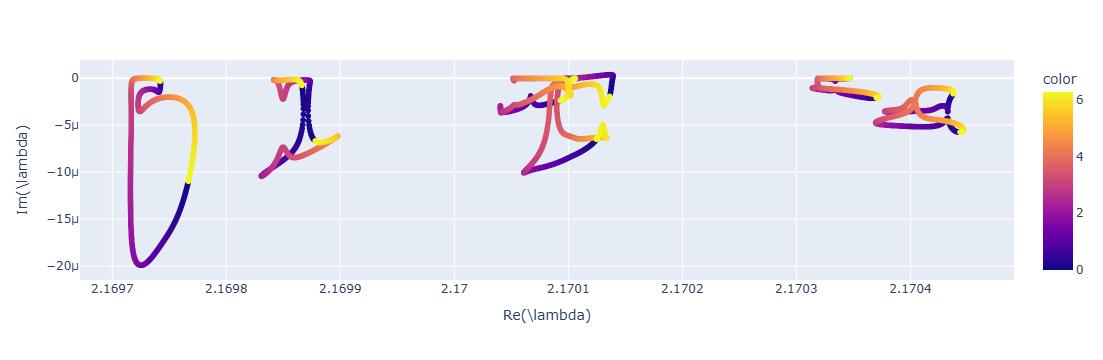

In [4]:
import searchep as sep
import os
import plotly.express as px
import numpy as np


DIRECTORY = os.getcwd()
INITIAL_DATASET = "Punkt23_initial_dataset_biggest_radius.csv"
EXTRA_TRAININGS_STEP = False
POINT = "Punkt23"
NEW_CALCULATIONS = False
EPS = 1.e-15
EPS_DIFF = 1.e-8  # default
KAPPA_SPACE_FILENAME = "_kappa_space_test_biggest_radius2.html"
DATFILE_KAPPA_EV_TS_NAME = "_data_test_biggest_radius2.csv"
KERNEL_EVS_PICKLE = "_kernel_evs_biggest_radius.pkl"
NEW_INITIAL_DATASET = "Punkt23_new_initial_dataset.csv"


def training_loop():
    training_data = sep.data.Data(INITIAL_DATASET, DIRECTORY, output_name=101)
    sep.training.train(training_data, new_calculations=NEW_CALCULATIONS, plotname="biggest_radius_")
    sep.eval.kappa_space_training_plotly("{}{}".format(POINT, KAPPA_SPACE_FILENAME), training_data)
    sep.eval.data_kappa_ev_ts_file("{}{}".format(POINT, DATFILE_KAPPA_EV_TS_NAME), training_data)
    sep.eval.save_kernel_evs("{}{}".format(POINT, KERNEL_EVS_PICKLE), training_data)


def training_loop_less_data_points():
    training_data = sep.data.Data(INITIAL_DATASET, DIRECTORY, output_name=201)
    training_data.ev = training_data.ev[::4]
    training_data.kappa = training_data.kappa[::4]
    training_data.kappa_scaled = training_data.kappa_scaled[::4]
    training_data.phi = training_data.phi[::4]
    training_data.training_steps_color = training_data.training_steps_color[::4]
    sep.training.train(training_data, new_calculations=NEW_CALCULATIONS, plotname="less_data_points")
    sep.eval.kappa_space_training_plotly("{}{}".format(POINT, KAPPA_SPACE_FILENAME), training_data)
    sep.eval.data_kappa_ev_ts_file("{}{}".format(POINT, DATFILE_KAPPA_EV_TS_NAME), training_data)
    sep.eval.save_kernel_evs("{}{}".format(POINT, KERNEL_EVS_PICKLE), training_data)
    
    
def initial_training_set():
    init_data = sep.data.Data("output_001_1.dat",
                              directory=DIRECTORY, evs_ep=False)
    init_data.ev = sep.data.get_permutations(init_data.vec)
    #init_data.ev = init_data.ev[:, [0, 1]]  # 0 and 1 are the columns of the array and belong to the first permutation. Change numbers to investigate the respective permutation.
    phi_all = np.sort(np.array([init_data.phi.copy() for _ in range(np.shape(init_data.ev)[1])]).ravel())
    fig_all = px.scatter(x=init_data.ev.ravel().real, y=init_data.ev.ravel().imag, color=phi_all,
                         labels=dict(x="Re(\\lambda)", y="Im(\\lambda)"))
    fig_all.show()
    #sep.eval.write_new_dataset(NEW_INITIAL_DATASET, init_data)  # After selecting a permutation this command can be used to save the data to a csv file.


if __name__ == "__main__":
    #training_loop()
    #training_loop_less_data_points()
    initial_training_set()